In [2]:
"""
Loads the 10x Genomics data and renames barcodes.
Loads AIRRPORT dat (parquet file)
"""
import pandas as pd
import singlecellexperiment as sce
import celldex
import singler


airrport_path='/dsi/efroni-lab/AIRRPORT/singlecell_breast/results/Tumor/airrport/matched_SRX10124709_unaligned_reads_plusCBUB_trimmed_R2.parquet'
### AIRRPORT results ###
print(f"\n--- Loading AIRRPORT data from {airrport_path} ---")
df_airrport = pd.read_parquet(airrport_path)
# Clean Cell Barcode (CB)
df_airrport['CB'] = df_airrport['CB'].astype(str).str.replace('Z:', '', regex=False)
df_airrport['CB'] = df_airrport['CB'].str.replace('*', '-1', regex=False)
df_airrport['CB'] = df_airrport['CB'].str.replace('-1', '', regex=False)
print(df_airrport.head())

print(f"\n--- Loading single cells Data ---")
sc_path ='/dsi/efroni-lab/AIRRPORT/test_env/sc/GEX/SRX10124709/SRX10124709_gex/outs/filtered_feature_bc_matrix.h5'
sc_data = sce.read_tenx_h5(sc_path, realize_assays=True)
mat = sc_data.assay("counts")
features = [str(x) for x in sc_data.row_data["name"]] #genes
print(features)
# Access cell barcodes
barcodes = [str(x) for x in sc_data.col_data["barcodes"]]
# Replace '-1' with empty string
barcodes = [x.replace("-1", "") for x in barcodes]
# Print all barcodes (or first 10 for brevity)
print(f'Number of barcodes(cells): {len(barcodes)}')

ref_data = celldex.fetch_reference("blueprint_encode", "2024-02-26", realize_assays=True)

results = singler.annotate_single(
    test_data = mat,
    test_features = features,
    ref_data = ref_data,
    ref_labels = ref_data.get_column_data().column("label.main"),
)

annotation_labels = list(results.column("best"))

df_annotations = pd.DataFrame({
    'Cell_Barcode': barcodes,
    'Annotation_Label': annotation_labels
})

print("\n--- SingleR Annotations Matched to Barcodes ---")
print(df_annotations.head())

# You can also see a summary of the cell types found
print("\n--- Annotation Summary ---")
# Print the counts for each cell type
print("\n--- Annotation Summary (Counts per Type) ---")
counts_per_type = df_annotations['Annotation_Label'].value_counts()
print(counts_per_type)

# Print the total sum line
print("\n--- Total Cells Annotated ---")
total_cells = len(df_annotations)
print(f"Total Cells: {total_cells}")

# Check for any 'None' or 'NaN' values in the 'Annotation_Label' column
missing_annotations = df_annotations['Annotation_Label'].isnull().sum()

print(f"\n--- Check for Missing Annotations ---")
if missing_annotations > 0:
    print(f"Found {missing_annotations} cells that SingleR could not annotate (None/NaN).")
else:
    print("All cells were successfully annotated by SingleR.")

# To be extra safe, you can check the 'Cell_Barcode' column too,
# but this is less likely to have nulls if it came from the h5 file.
missing_barcodes = df_annotations['Cell_Barcode'].isnull().sum()
print(f"Number of rows with missing Cell_Barcode: {missing_barcodes}")

#In the tumor single-cell sample SRX10124709, there are 3,994 cells in total, and 2,440 of them are T cells.

print("\n--- Merge annotation to AIRRPORT ---")
airrport_with_anno = df_airrport.merge(
    df_annotations,
    how="left",
    left_on="CB",
    right_on="Cell_Barcode"
)
airrport_with_anno.head()


if 'GTTCTCGTTTGAATAT'  in barcodes:
    print("\n--- Barcode 'GTTCTCGTTTGAATAT' found in single-cell data ---")
else:
    print("\n--- Barcode 'GTTCTCGTTTGAATAT' NOT found in single-cell data ---")

unique_cdr3_count = airrport_with_anno["CDR3_match"].nunique()
print("Number of unique CDR3 sequences:", unique_cdr3_count)


df_tcells = airrport_with_anno[airrport_with_anno["Annotation_Label"].str.contains("T-cells", na=False)]
counts = df_tcells.groupby("Annotation_Label")["CDR3_match"].nunique()
print(counts)
df_tcells = airrport_with_anno[airrport_with_anno["Annotation_Label"].str.contains("T-cells", na=False)]
counts = df_tcells.groupby("Annotation_Label")["CDR3_match"].nunique()
print(counts)


num_barcodes_with_sequences = airrport_with_anno["CB"].nunique()
num_barcodes_with_sequences
print("Number of unique barcodes with sequences:", num_barcodes_with_sequences)



--- Loading AIRRPORT data from /dsi/efroni-lab/AIRRPORT/singlecell_breast/results/Tumor/airrport/matched_SRX10124709_unaligned_reads_plusCBUB_trimmed_R2.parquet ---
                     seq_id      CDR3_match           UMI                CB
0  SRR13737345.107895554|-1        CASSPPPP  Z:GGGCGGTGGT  GCGCAGTCAAATTGCC
1  SRR13737348.138379414|-0        CARGAGGV  Z:TTCAGCTCGG  TTATGCTCATGCCTAA
2  SRR13737348.146180757|+0        CASEGGGG  Z:TTGCTACTAC  GTTCTCGTTTGAATAT
3  SRR13737347.181036790|-0  FDPWGQGTLVTVSS  Z:CTCATTACGG  CACACCTTCATCTGCC
4   SRR13737348.64724378|+2        CASEGGGG  Z:ACCCTTCTCC  CTGCTGTTCACATGCA

--- Loading single cells Data ---


/home/ls/linoym/.conda/envs/airrport/lib/python3.11/site-packages/singlecellexperiment/io/tenx.py:112: UserWarning: These columns from h5 are ignored - _all_tag_keys because of inconsistent length with the count matrix.
  warn(


['DDX11L2', 'MIR1302-2HG', 'FAM138A', 'ENSG00000290826', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448', 'ENSG00000236601', 'ENSG00000290385', 'OR4F29', 'ENSG00000235146', 'OR4F16', 'ENSG00000291215', 'ENSG00000229905', 'LINC01409', 'ENSG00000290784', 'FAM87B', 'LINC00115', 'LINC01128', 'ENSG00000288531', 'FAM41C', 'ENSG00000272438', 'ENSG00000230699', 'ENSG00000241180', 'LINC02593', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'ENSG00000272512', 'HES4', 'ISG15', 'ENSG00000224969', 'AGRN', 'ENSG00000242590', 'ENSG00000291156', 'ENSG00000273443', 'RNF223', 'C1orf159', 'ENSG00000285812', 'LINC01342', 'ENSG00000272141', 'TTLL10-AS1', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'B3GALT6', 'C1QTNF12', 'ENSG00000260179', 'UBE2J2', 'LINC01786', 'SCNN1D', 'ACAP3', 'PUSL1', 'INTS11', 'ENSG00000240731', 'CPTP', 'TAS1R3', 'DVL1', 'MXRA8', 'AURKAIP1', 'CCNL2', 'MRPL20-AS1', 'MRPL20', 'MRPL20-DT', 'ANKRD65', 'ANKRD65-AS1', 


--- Performing PCA and UMAP for visualization ---


/home/ls/linoym/.conda/envs/airrport/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


--- Generating UMAP plot colored by SingleR Annotation ---
--- Generating UMAP plot colored by SingleR Annotation ---


<Figure size 1200x1000 with 0 Axes>

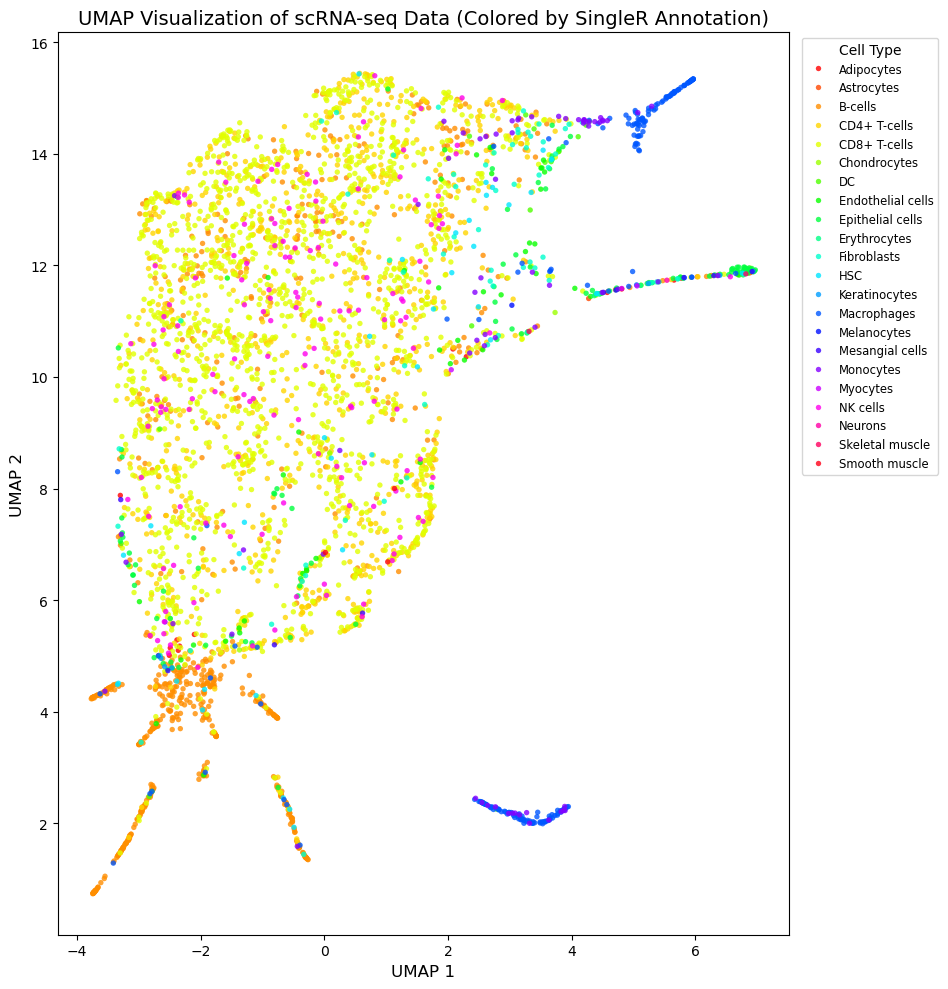

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import matplotlib as mpl
import numpy as np

# --- 1. Dimensionality Reduction (PCA -> UMAP) ---
print("\n--- Performing PCA and UMAP for visualization ---")
# Transpose the counts matrix (cells x features format for PCA/UMAP)
mat_t = mat.T

# Perform PCA
n_pcs = 50
pca = PCA(n_components=n_pcs, random_state=42)
pca_results = pca.fit_transform(mat_t)

# Perform UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)
umap_results = reducer.fit_transform(pca_results)

# Create a DataFrame for UMAP coordinates
df_umap = pd.DataFrame({
    'UMAP_1': umap_results[:, 0],
    'UMAP_2': umap_results[:, 1],
    'Cell_Barcode': barcodes
})

# Merge UMAP coordinates with Annotations for plotting
df_plot = df_annotations.merge(
    df_umap, 
    on='Cell_Barcode', 
    how='inner'
)

# --- 2. UMAP Visualization (UPDATED) ---

print("--- Generating UMAP plot colored by SingleR Annotation ---")

# 1. Ensure the plotting DataFrame is sorted and filtered
df_plot_filtered = df_plot.dropna(subset=['Annotation_Label']).sort_values(by='Annotation_Label')

# 2. Extract the order of labels to ensure consistent coloring
# We will sort them alphabetically to assign colors in an organized way
cell_type_order = sorted(df_plot_filtered['Annotation_Label'].unique())

plt.figure(figsize=(12, 10)) # Increased figure size for better clarity

print("--- Generating UMAP plot colored by SingleR Annotation ---")

# 1. הכנת נתונים
df_plot_filtered = df_plot.dropna(subset=['Annotation_Label']).sort_values(by='Annotation_Label')
cell_type_order = sorted(df_plot_filtered['Annotation_Label'].unique())
num_cell_types = len(cell_type_order)

# 2. יצירת מפת צבעים עם ניגודיות גבוהה
# נשתמש במפת הצבעים 'gist_ncar' או 'tab20' (אם מספיק) או 'hsv'
# 'hsv' היא מפת צבעים בעלת גוונים עזים ורבים, מעולה לניגודיות גבוהה
cmap = mpl.colormaps.get_cmap('hsv') # <--- בחירת מפת צבעים בעלת גוונים רבים
# יצירת רשימת צבעים (צבע אחד לכל סוג תא)
color_list = [cmap(i) for i in np.linspace(0, 1, num_cell_types)] 

# 3. יצירת פלוט
plt.figure(figsize=(12, 10)) 

scatter = sns.scatterplot(
    x='UMAP_1',
    y='UMAP_2',
    data=df_plot_filtered,
    hue='Annotation_Label',
    hue_order=cell_type_order, 
    palette=color_list,             # <--- שימוש ברשימת הצבעים המותאמת אישית
    s=15,                      
    alpha=0.8,                 
    linewidth=0 
)

# 4. התאמות גרף
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title="Cell Type", fontsize='small')
plt.title("UMAP Visualization of scRNA-seq Data (Colored by SingleR Annotation)", fontsize=14)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.tight_layout(rect=[0, 0, 0.8, 1]) 
plt.show()

# --- (Rest of your existing code continues from here) ---